# Modelling continuous data with Tensoflow Probability

In this notebook you will learn how work with TFP. You will set up linear regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant standart deviation $\sigma$. The mean $\mu$ of the CPD will always depend linearly on the input. You will model the constant $\sigma$ by hand with the formula and Tensorflow probability and compare the optimal $\sigma$ from the formula with the solution of TFP.

**Dataset:** 
You work with a simulated dataset that looks a bit like a fish when visualized in a scatterplot. The data is simulated to have  a linear slope but non-constant variance. The variance starts with a large value then slowly decreases to increase again and in the end it decreases again. You split the data into train, validation and test dataset.

**Content:**
* Simulate and split the dataset 
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and a fixed standart deviation $\sigma$ by hand.
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and a fixed standart deviation $\sigma$ with TFP.
* Compare the two models based on the NLL loss and the optimal $\sigma$.



In [1]:
!pip install tensorflow==2.0.0

In [2]:
!pip install tensorflow_probability==0.8.0

#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


### Simulate the fishlike data

In the next few cells you will simulate some (x,y)-data where the y increases on average linerly with x but has non-constant variance that so that scatterplot looks like a fish.You will fist simulate random distributed noise with non constant variance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y = 2.7*x+noise (linear slope of 2.7 and intercept of 0). The variance of the noise will change, it starts with a high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance. 

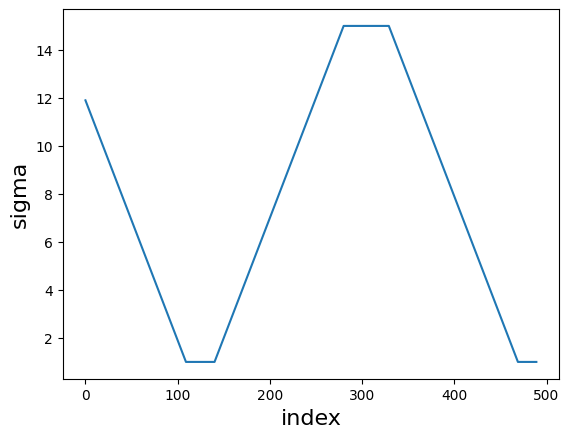

In [4]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()


Now you will sample uniformly distributed x values in the range from -1 to 6. You will sample less x values in the range from -1 to 1. Finally you sort the x values (for ploting reasons). 

In [0]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data complete. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [0]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [0]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

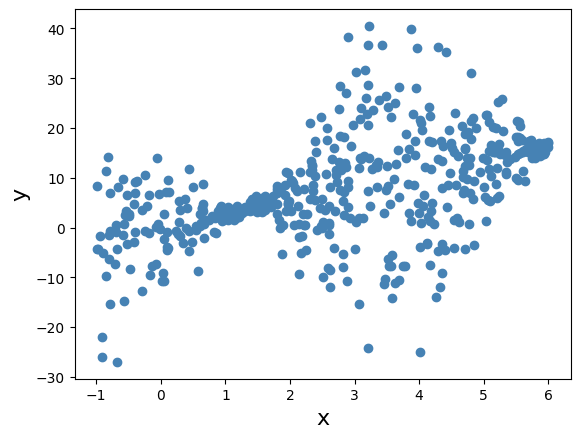

In [8]:
# lets visualize the data
plt.scatter(x,y,color="steelblue") 
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [0]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train different models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model. It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction. That is the reason why you will plot it only in the end.


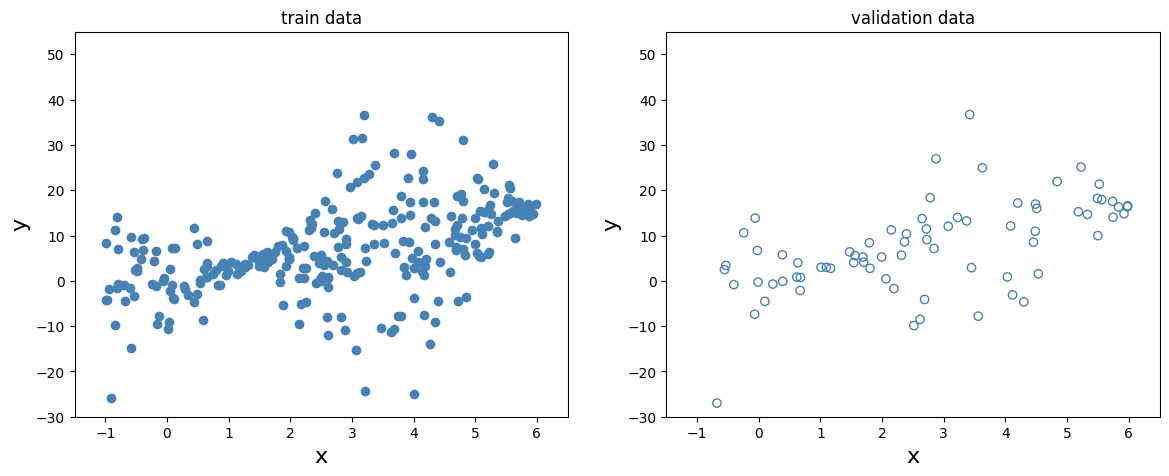

In [11]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Fit a linear regression model with constant variance
In the next cells you will define and fit a linear model on the simulated fish data with keras. You define a simple linear regression NN with only two parameters to model the output as a gaussian conditional probability distribution , for the loss we use the mse.

In [0]:
inputs = Input(shape=(1,))
params = Dense(1)(inputs) 

model_ = Model(inputs=inputs, outputs=params)
model_.compile(Adam(learning_rate=0.1), loss="mse") 

In [14]:
model_.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_.fit(x_train, y_train, epochs=8000, verbose=0, validation_data=(x_val,y_val),batch_size=len(x_train))

To calculate the  minimal NLL we need to know the optimal constant sigma that minimizes the NLL. To get the optimal sigma we use the formulat for the optimal signma and compute a slightly adjusted standart deviation of the residuals.

In [16]:
preds_train = model_.predict(x_train)
preds_val = model_.predict(x_val)

SSR= np.sum(np.square(y_train-preds_train))
sigma_=np.sqrt((SSR)/(len(x_train)))
sigma_

8.548499134794387

To calculate the NLL with the optimal constant sigma, you can use the formula for the $$NLL = \frac{1}{n}\sum_{i=1}^{n}- log(\frac{1}{\sqrt{2 \pi \sigma^2_x}})+\frac{(y_i - \mu_i)^2}{2 \sigma^2_x}$$ 


In [17]:
#loss with the estimated sigma
NLL_train=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                  ((np.square(y_train-model_.predict(x_train))/(2*np.square(sigma_)))))
print(NLL_train)
NLL_val=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model_.predict(x_val))/(2*np.square(sigma_)))))
print(NLL_val)

3.564694260954299
3.5333469290814996


Now you will plot the trained model with the resulting mean and +-2 sigma at each x value and see how well it fits the data. Remember in this model you used a linear model for the mean of the CPD and just fixed the standart deviation sigma to a constant value.

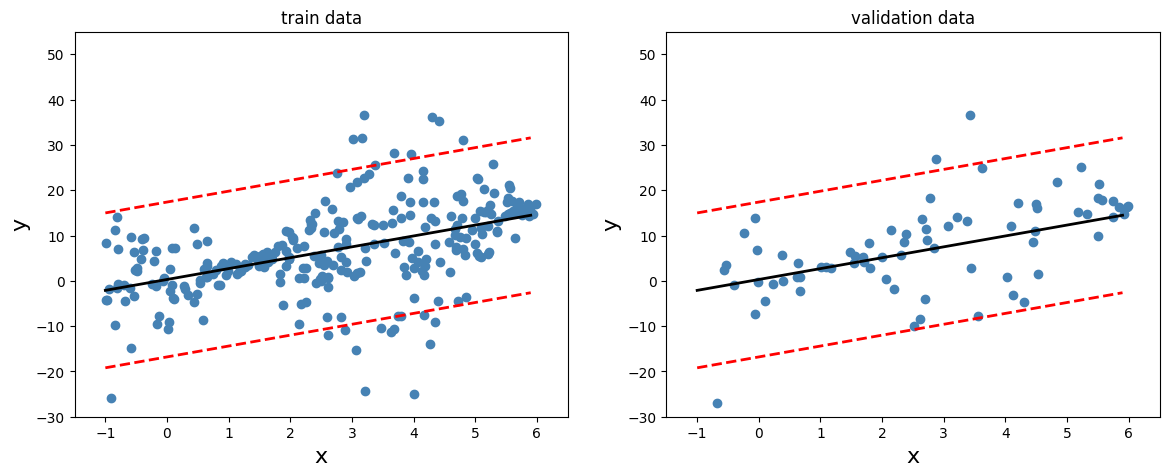

In [18]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_.predict(x_pred)
sigma = sigma_
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

## Fit a linear regression model with constant variance in TFP

Let's try to model the standart deviation sigma in a constant way and use the TFP Framework. For this we need to use a little trick. To define a constant standart deviation, you can use a Normal distribution in TFP and you fit both parameters the mean and sigma. You don't use any hidden layers in between. As loss function we use the NLL.

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) #A

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable #C #D

input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
out1 = Dense(1)(input1) #B
out2 = Dense(1,use_bias=False)(input2) #B
params = Concatenate()([out1,out2]) #C
dist = tfp.layers.DistributionLambda(my_dist)(params) #C #D

model_const_sd = Model(inputs=[input1,input2], outputs=dist) ## use a trick with two inputs, input2 is just ones
model_const_sd.compile(tf.keras.optimizers.Adam(1), loss=NLL) 

#A Define NLL of the model 
#B Setting up the NN with two output node
#C The first output node defines the mean (loc)
#D The second output defines the standard deviation (scale) via the softplus function 

In [20]:
model_const_sd.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            2           input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            1           input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
history = model_const_sd.fit([x_train,np.expand_dims(np.ones(len(x_train)),1)], y_train, batch_size=len(x_train), epochs=8000, verbose=0, 
                                validation_data=([x_val,np.expand_dims(np.ones(len(x_val)),1)],y_val))

In the next cell you define two models to predict the mean $\mu$ and the standart deviation $\sigma$ of the output distribution.

In [0]:
model_const_sd_mean = Model(inputs=[input1,input2], outputs=dist.mean())
model_const_sd_sd = Model(inputs=[input1,input2], outputs=dist.stddev())

In [23]:
model_const_sd_sd.predict([x_train,np.expand_dims(np.ones(len(x_train)),1)])[0:5]

array([[8.548009],
       [8.548009],
       [8.548009],
       [8.548009],
       [8.548009]], dtype=float32)

In [24]:
sigma_

8.548499134794387

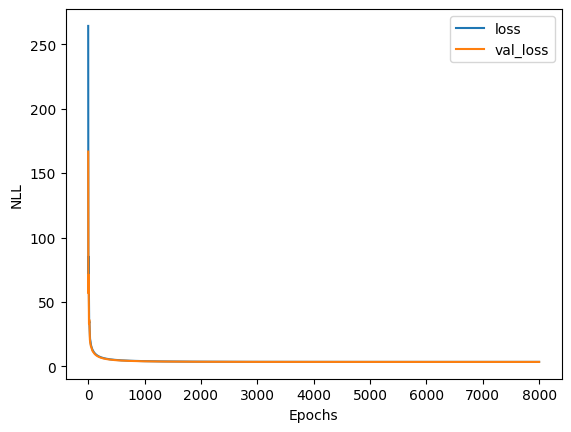

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

#### Result:  constant sigma TFP

In [26]:
print(model_const_sd.evaluate([x_train,np.expand_dims(np.ones(len(x_train)),1)],y_train, verbose=0))
print(model_const_sd.evaluate([x_val,np.expand_dims(np.ones(len(x_val)),1)],y_val, verbose=0))


3.564694093762811
3.5333431218121505


In [27]:
#loss with the estimated sigma
NLL_train=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                  ((np.square(y_train-model_.predict(x_train))/(2*np.square(sigma_)))))
print(NLL_train)
NLL_val=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model_.predict(x_val))/(2*np.square(sigma_)))))
print(NLL_val)

3.564694260954299
3.5333469290814996


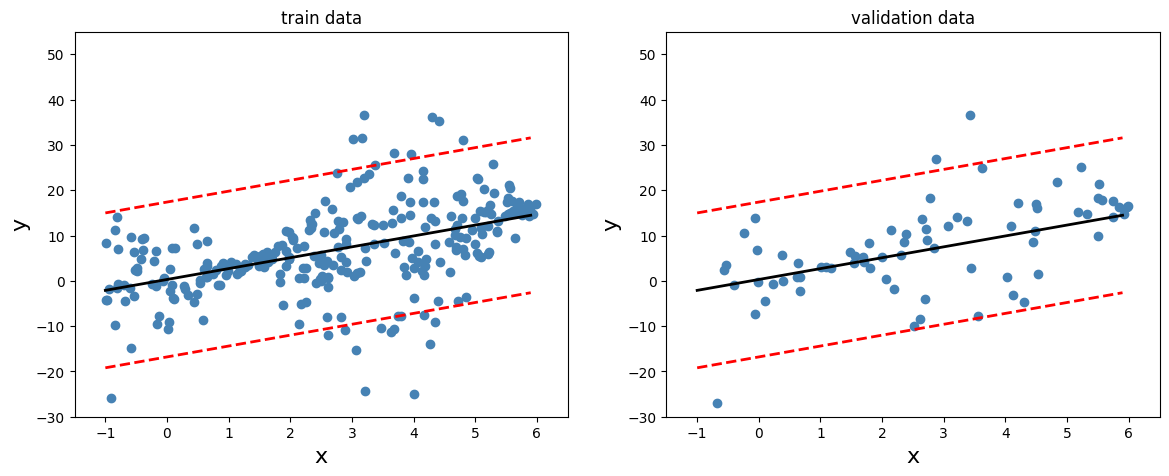

In [28]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_const_sd_mean.predict([x_pred,np.expand_dims(np.ones(len(x_pred)),1)])
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_const_sd_sd.predict([x_pred,np.expand_dims(np.ones(len(x_pred)),1)]),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_const_sd_sd.predict([x_pred,np.expand_dims(np.ones(len(x_pred)),1)]),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_const_sd_sd.predict([x_pred,np.expand_dims(np.ones(len(x_pred)),1)]),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_const_sd_sd.predict([x_pred,np.expand_dims(np.ones(len(x_pred)),1)]),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

Yout see that the optimal sigma in both models is the same with very small differences, the NLL loss for both models is also practically the same in the train dataset.